In [4]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression #Build our model
from sklearn.metrics import mean_absolute_error #Evaluate our model
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [5]:
def wrangle(filepath):
    # Read CSV file into DataFrame
    df = pd.read_csv(filepath)
    
    # Subset to properties in '"Capital Federal"'
    mask_ba=df["place_with_parent_names"].str.contains("Capital Federal")
    
    
    # Subset to '"Apartment"'
    mask_apt = df["property_type"] == "apartment"
    
    # Subset to properties where '"price_aprox_usd"' <400_000
    mask_price =df["price_aprox_usd"] < 400_000
    
    df = df[mask_ba & mask_apt & mask_price] 
    
    # Remove outliers by '"surface_covered_in_m2"'
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low,high)
    df = df[mask_area]
    
    return df

In [6]:
df = wrangle("buenos_real_state_1.csv")
print("df shape:", df.shape)
df.head()

df shape: (1315, 17)


,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
2,3,sell,apartment,|Argentina|Capital Federal|Recoleta|,"-34.5889927,-58.4001326",215000.0,USD,3259916.00,215000.00,40.0,35.0,5375.000000,6142.857143,NaN,1.0,3500.0,http://recoleta.properati.com.ar/12j4v_venta_d...
9,10,sell,apartment,|Argentina|Capital Federal|Recoleta|,"-34.5880437,-58.3980657",341550.0,USD,5178717.72,341550.00,NaN,90.0,NaN,3795.000000,8.0,2.0,NaN,http://recoleta.properati.com.ar/100t0_venta_d...
12,13,sell,apartment,|Argentina|Capital Federal|Monserrat|,"-34.6233199695,-58.3974607122",1386000.0,ARS,1382153.13,91156.62,39.0,33.0,2337.349231,42000.000000,NaN,NaN,NaN,http://monserrat.properati.com.ar/t05l_venta_d...
13,14,sell,apartment,|Argentina|Capital Federal|Belgrano|,"-34.553897,-58.451939",105000.0,USD,1592052.00,105000.00,NaN,33.0,NaN,3181.818182,1.0,1.0,NaN,http://belgrano.properati.com.ar/zsd5_venta_de...
17,18,sell,apartment,|Argentina|Capital Federal|Villa del Parque|,"-34.6288131,-58.4722301",89681.0,USD,1359779.19,89681.00,46.0,39.0,1949.586957,2299.512821,NaN,1.0,1500.0,http://villa-del-parque.properati.com.ar/12q2f...


In [7]:
# Check your work
assert(
   len(df) <=1343
), f"'df' should have no more than 1343 observations, not {len(df)}."


''

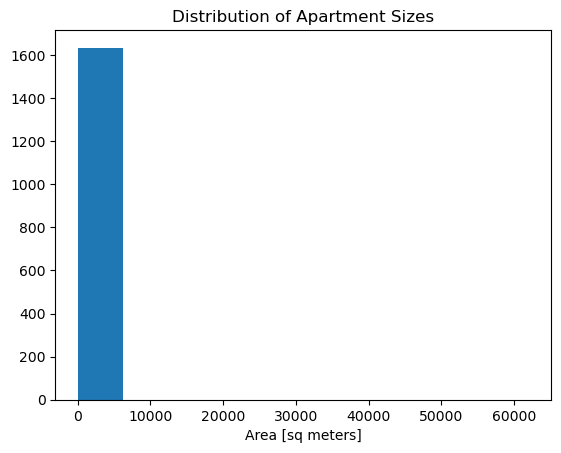

In [38]:
# Create a histogram of "surface_covered_in_m2". Make sure that the x-axis has the label "Area [sq meters]" and the plot has the title "Distribution of Apartment Sizes"

plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes")
;

# Conclusion of Histogram
It suggests that there are outliers in your dataset. This can affect model performance — especially in the sorts of linear models and has a skewed distribution

In [28]:
# Calculate the summary statistics for df using the describe method.

df.describe()["surface_covered_in_m2"]

count     1635.000000
mean        97.877064
std       1533.057610
min          0.000000
25%         38.000000
50%         50.000000
75%         73.000000
max      62034.000000
Name: surface_covered_in_m2, dtype: float64

# Conclusion:
While most of the apartments in our dataset are smaller that 73 square meters, there are some that are several thousand square meters so we will again update wrangle function for the outliers. 

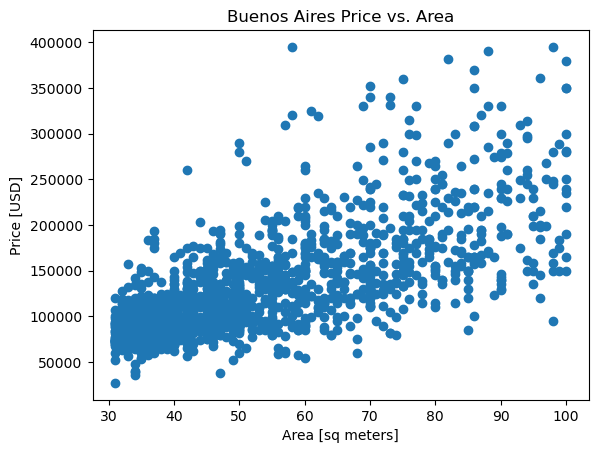

In [8]:
# Create a scatter plot that shows price ("price_aprox_usd") vs area ("surface_covered_in_m2") in our dataset. Make sure to label your x-axis "Area [sq meters]" and your y-axis "Price [USD]"

plt.scatter( x=df["surface_covered_in_m2"],y= df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires Price vs. Area");

# Conclusion:
This plot suggests that there's a moderate positive correlation between apartment price and size. This means that if thing we want to predict is price, size will be a good feature to include.

In [13]:
# Create the feature matrix named X_train, which you'll use to train your model. It should contain one feature only: ["surface_covered_in_m2"]. Remember that your feature matrix should always be two-dimensional.

features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.head()



,surface_covered_in_m2
4,70.0
9,42.0
29,54.0
40,42.0
41,50.0


In [12]:
X_train.shape

(1343, 1)

In [17]:
# Check your work
assert X_train.shape == (
                         31343,
                         1,
                        ), f"The shape of 'X_train' should be (1343,1), not {X_train.shape}."


In [22]:
# Create the target vector named y_train, which you'll use to train your model. Your target should be "price_aprox_usd"

target = "price_aprox_usd"
y_train = df[target]
y_train.shape
y_train.head()

4     129000.0
9      87000.0
29    118000.0
40     57000.0
41     90000.0
Name: price_aprox_usd, dtype: float64

In [29]:
#  Baseline :Calculate the mean of your target vector y_train and assign it to the variable y_mean

y_mean=y_train.mean()
y_mean

135527.83871928515

In [30]:
# Create a list named y_pred_baseline that contains the value of y_mean repeated so that it's the same length at y

y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:5]

[135527.83871928515,
 135527.83871928515,
 135527.83871928515,
 135527.83871928515,
 135527.83871928515]

In [32]:
type(X_train["surface_covered_in_m2"])

pandas.core.series.Series

In [36]:
type(X_train.values)
X_train.values[:5]

array([[70.],
       [42.],
       [54.],
       [42.],
       [50.]])

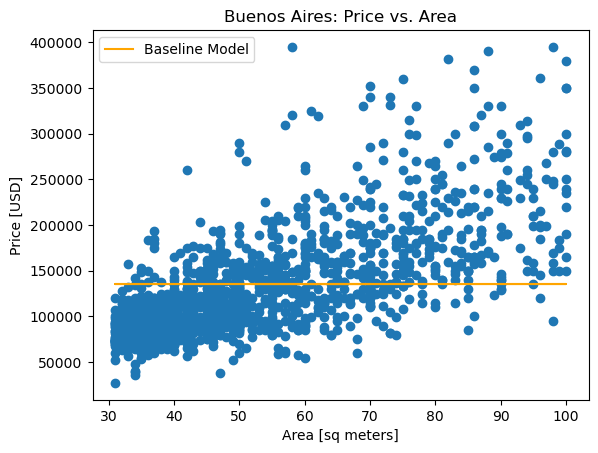

In [33]:
# Add a line to the plot below that shows the relationship between the observations X_train and our dumb model's predictions y_pred_baseline. Be sure that the line color is orange, and that it has the label "Baseline Model"
plt.plot(X_train["surface_covered_in_m2"], y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

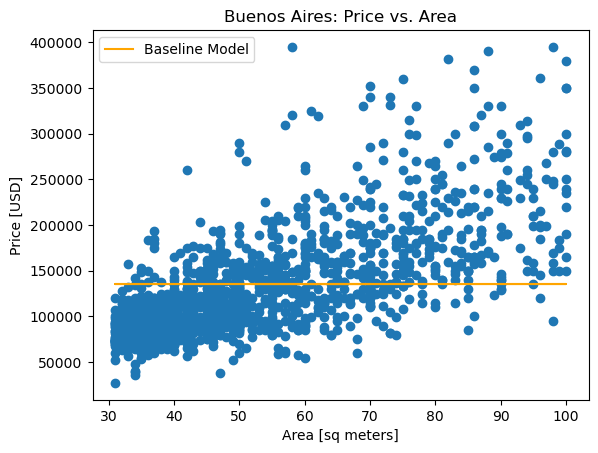

In [35]:
# alternate ways
plt.plot(X_train.values, y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

# Conclusion:
 It seems like our baseline model doesn't really follow the trend in the data.


In [38]:
# Calculate the baseline mean absolute error for your predictions in y_pred_baseline as compared to the true targets in y

mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price: 135527.84
Baseline MAE: 45199.46


Conclusion
If we always predicted that an apartment price is $135,527.84, our predictions would be off by an average of $45,199.46. It also tells us that our model needs to have mean absolute error below $45,199.46 in order to be useful.

In [42]:
# Instantiate a LinearRegression model named model

model = LinearRegression()

In [45]:
 # Check your work
assert isinstance(model, LinearRegression)

In [46]:
# Fit your model to the data, X_train and y_train

model.fit(X_train, y_train)

LinearRegression()

In [47]:
# Check your work
check_is_fitted(model)

In [48]:
# Using your model's predict method, create a list of predictions for the observations in your feature matrix X_train. Name this array y_pred_training

y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668])

In [50]:
# Check your work
assert (
   len(y_pred_training) ==1343
 ), f"There should be 1343 prediction in 'y_pred_training' , not{len(y_pred_training)}."

In [51]:
#  Calculate your training mean absolute error for your predictions in y_pred_training as compared to the true targets in y_train

mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 31248.26


# Conclusion:
Our model beat the baseline by over $10,000! That's a good indicator that it will be helpful in predicting apartment prices.

In [52]:
# Run the code below to import your test data buenos-aires-test-features.csv into a DataFrame and generate a Series of predictions using your model. Then run the following cell to submit your predictions to the grader

X_test = pd.read_csv("buenos_real_state-test_feature.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    117330.058901
1    135355.037823
2     88039.468152
3     88039.468152
4    106064.447074
dtype: float64

In [54]:
# Extract the intercept from your model, and assign it to the variable intercept.

intercept = model.intercept_
print("Model Intercept:", intercept)
assert any([isinstance(intercept, int), isinstance(intercept, float)])

Model Intercept: 11433.307732797795


In [55]:
# Extract the coefficient associated "surface_covered_in_m2" in your model, and assign it to the variable coefficient

coefficient = round(model.coef_[0], 2)
print('Model coefficient for "surface_covered_in_m2":', coefficient)
assert any([isinstance(coefficient, int) , isinstance(coefficient, float)])

Model coefficient for "surface_covered_in_m2": 2253.12


In [56]:
# print the equation that your model has determined for predicting apartment price based on size.

print(f"apt_price = {intercept} + {coefficient} * surface_covered")

apt_price = 11433.307732797795 + 2253.12 * surface_covered


# Conclusion:
equation is in form y= Bo + B1x

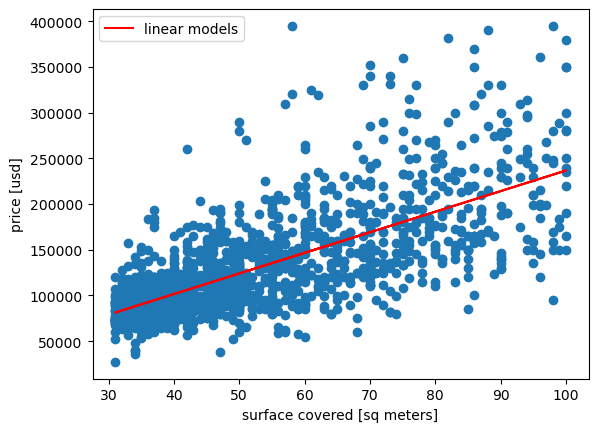

In [58]:
# Add a line to the plot below that shows the relationship between the observations in X_train and your model's predictions y_pred_training. Be sure that the line color is red, and that it has the label "Linear Model"
plt.plot(X_train.values, model.predict(X_train), color="red", label="linear models")
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.legend();